In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import fftpack
from matplotlib.widgets import SpanSelector
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import random

--------------------------------------------------
FSR:  0.016453894
Finesse 22614.10235636336
Finesse 22614.10235636336
Finesse 7708.444139809781
--------------------------------------------------
--------------------------------------------------
FSR:  0.017781900000000003
Finesse 32317.89490248417
Finesse 32317.89490248417
Finesse 12333.646047501403
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
FSR:  0.017487500000000003
Finesse 17644.28319903336
Finesse 17644.28319903336
Finesse 5935.937723616313
--------------------------------------------------
--------------------------------------------------
FSR:  0.016872500000000012
Finesse 17813.894537153767
Finesse 17813.894537153767
Finesse 5590.566298665002
--------------------------------------------------
--------------------------------------------------
FSR:  0.015688499999999994
Finesse 161797.42675294212
Finesse 161797.4267529

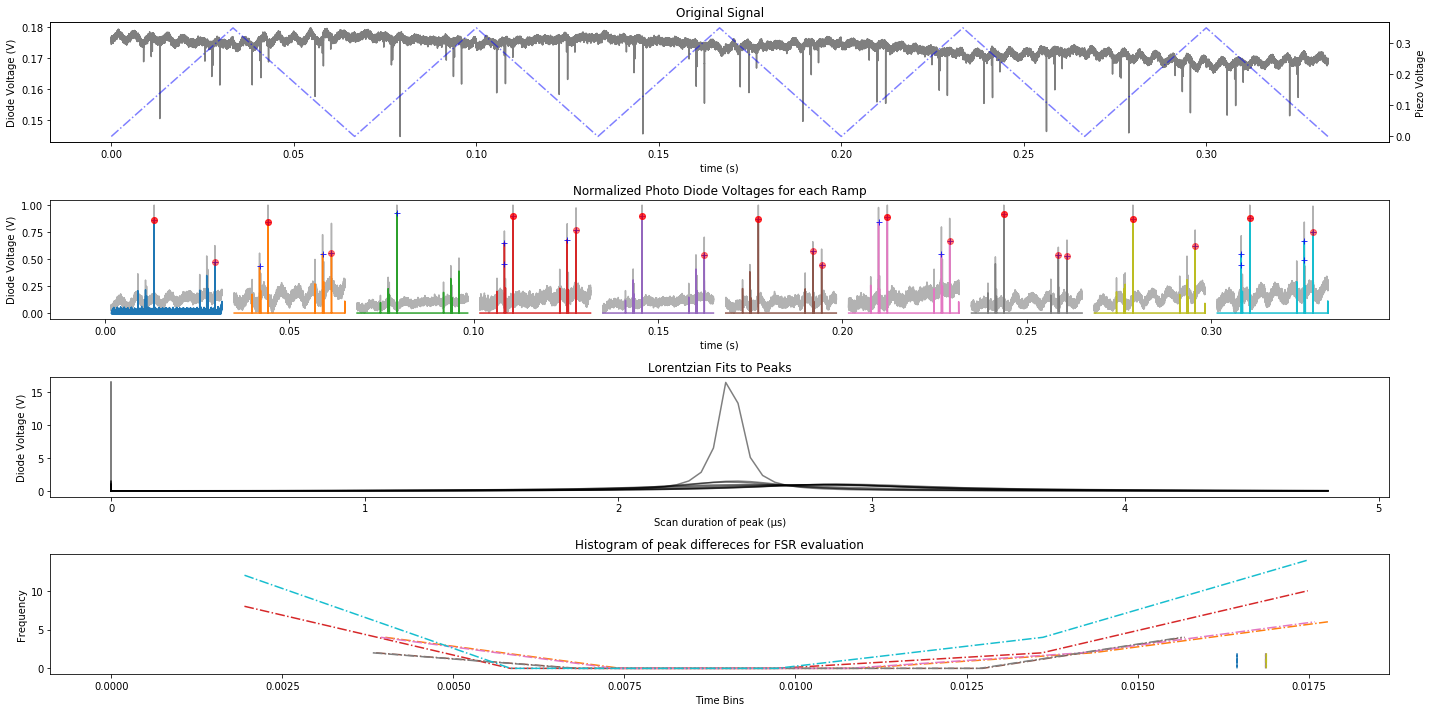

In [643]:
def normalize(V):
    return (V-np.amin(V))/np.amax((V-np.amin(V)))


def lorentzian(lbd, lbd0, Gamma, I, c):
    return I * 1/np.pi * 1/2*Gamma/( (lbd-lbd0)**2 + (1/2*Gamma)**2 ) + c


def gaussian(x, mu, sigma, I):
    return I*1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))


def estimate_lorentzian(t, V):
    
    mu_est = np.argmax(V)
    Gamma_est = t[-1]-t[0]
    I_est = 2/(Gamma_est*np.pi)
    c_est = 0
    
    p0 = [mu_est, Gamma_est, I_est, c_est]
    bounds = ([t[0], 0, 0, 0], [t[-1],  2*Gamma_est, 2*I_est, 0.1])
    popt, pcov = curve_fit(lorentzian, t, V, p0=p0, bounds=bounds)
    
    try:
        popt, pcov = curve_fit(lorentzian, t, V, p0=p0, bounds=bounds)
        lbd0, Gamma, I, c = popt
        return lbd0, Gamma, I, c

    except RuntimeError as re:
        print("To few data points: ", re)
        return None

    except ValueError as ve:
        print("Value error: ", ve)
        return None
    

def high_pass(t, V, nu_cutoff):
    N = len(V)
    nu = np.fft.fftfreq(N,t[1]-t[0])
    fft = np.fft.fft(V)
    fft[np.where(np.abs(nu)<nu_cutoff)[0]] = 0
    V = np.fft.ifft(fft)
    return nu, np.real(V)


eps = 0.05
# # Pick cavity scan data from bichromatic scans
# Tk().withdraw() 
# scan1 = askopenfilename() 
# scan2 = askopenfilename() 

# Get relevant meta info
# with open(filename, "r") as _file:
#     for line in _file.readlines():
#         if "Ramp " in line:
#             num_ramps = line.split()[-1]
#         if "Clock Frequency" in line:
#             clock_freq = line.split()[-1]
#         if "ScanSpeed" in line:
#             scan_freq = line.split()[-1]

scan1 = np.genfromtxt(open(r"C:\Users\Marco\Desktop\Github\Quantum-Dynamics\Resonator\Cryo Fiber Spectra\20201117-1128-01_cavity_scan.dat", "rb"), delimiter="\t")
scan2 = np.genfromtxt(open(r"C:\Users\Marco\Desktop\Github\Quantum-Dynamics\Resonator\Cryo Fiber Spectra\Bichromatic 737 Scan\20201117-1634-55_cavity_scan.dat", "rb"), delimiter="\t")
scans = np.stack((scan1, scan1))


# Open counts from photodiode with format Piezo Voltage (V), Diode Voltage (V/bin), Voltage/bin
t = scans[0,:,2]
V_Piezo = scans[0,:,0]
V_Diode = 1-scans[0,:,1]


fig, axs = plt.subplots(4,1, figsize=(20,10))
axs[0].plot(t, scans[0,:,1], '-k', alpha=0.5)
axs[0].set_title("Original Signal")
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("Diode Voltage (V)")
axs01 = axs[0].twinx()
axs01.plot(t, V_Piezo, '-.b', alpha=0.5)
axs01.set_ylabel("Piezo Voltage")


# Split ramps by looking for voltage minima and maxima in piezo voltage
ramp_min_idxs = (np.where(V_Piezo == np.amin(V_Piezo))[0]).astype(int)
ramp_max_idxs = (np.where(V_Piezo == np.amax(V_Piezo))[0]).astype(int)

# Filter out duplicate ramp minima
temp = [ramp_min_idxs[0]]
for i in range(1,len(ramp_min_idxs)):
    if (ramp_min_idxs[i]-ramp_min_idxs[i-1])>1:
        temp.append(ramp_min_idxs[i])
    else:
        continue    
ramp_min_idxs = temp

# Filter out duplicate ramp maxima
temp = [ramp_max_idxs[0]]
for i in range(1,len(ramp_max_idxs)):
    if (ramp_max_idxs[i]-ramp_max_idxs[i-1])>1:
        temp.append(ramp_max_idxs[i])
    else:
        continue    
ramp_max_idxs = temp


# Calculate ramp indices by discriminating between starting downward and upward ramp,
# which leads to either more maxima or minima in piezo voltage
ramps = []
if len(ramp_min_idxs) > len(ramp_max_idxs):
    for i in range( min( len(ramp_min_idxs), len(ramp_max_idxs) ) ):
        ramps.append([ramp_min_idxs[i], ramp_max_idxs[i]])
        ramps.append([ramp_max_idxs[i], ramp_min_idxs[i+1]])
else:
    for i in range( min( len(ramp_min_idxs), len(ramp_max_idxs) ) ):
        ramps.append([ramp_max_idxs[i], ramp_min_idxs[i]])
        ramps.append([ramp_min_idxs[i], ramp_max_idxs[i+1]])

# Threshold in percent of maximum resonance
threshold = 0.5
num_peak_pts = 10
fundamental_mode_idxs = []
fsr = []
for j, ramp in enumerate(ramps):
    print(50*"-")    
    #Truncate ramp to stay away from inflection points
    ramp = np.arange(ramp[0] + int((eps)*(ramp[1]-ramp[0])) , ramp[0] + int((1-eps)*(ramp[1]-ramp[0])) )
    
    t_ramp = t[ramp]
    V_Piezo_ramp = V_Piezo[ramp]
    V_Diode_ramp = V_Diode[ramp]

    # Make sure that resonances appear in the same "direction"
    if V_Piezo_ramp[2]-V_Piezo_ramp[0]<0:
        V_Diode_ramp = V_Diode_ramp[::-1]
    
    # Normalize to range of 0 and 1
    V_Diode_ramp_norm = normalize(V_Diode_ramp)
    
    # Apply highpass filter with cutoff of 1000Hz for laser polarization drifts
    nu, V_Diode_ramp_norm = high_pass(t_ramp, V_Diode_ramp_norm, 1000)
    
    # Denoise gaussian white noise by fitting a histogram of counts ot a gaussian function
    # and setting a threshold of 5*sigma+mu for signal
    hist, bins = np.histogram(V_Diode_ramp_norm, bins=100)
    bins = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
    (mu, sigma, A), pcov = curve_fit(gaussian, bins, hist)
    V_Diode_ramp_norm[np.where(V_Diode_ramp_norm<5*sigma+mu)[0]] = 0

    axs[1].plot(t_ramp, normalize(V_Diode_ramp), '-k', alpha=0.3, linewidth=1.5)
    axs[1].plot(t_ramp, V_Diode_ramp_norm, linewidth=1.5)
    
    # Filter out single peaks by looking for all elements greater than x (e.g. 0.5) 
    peaks_idxs = np.where(V_Diode_ramp_norm >= threshold*np.amax(V_Diode_ramp_norm))[0]
    
    # Split the resulting array of indices containing a peak by looking for discontinouities
    # in the index array which corresponds to the next peak
    peaks_maxs_ramp = []
    for peak_idxs in np.array_split( peaks_idxs, np.where(np.diff(peaks_idxs)>2)[0] + 1):
        axs[1].plot(t_ramp[peak_idxs[np.argmax(V_Diode_ramp_norm[peak_idxs])]], V_Diode_ramp_norm[peak_idxs[np.argmax(V_Diode_ramp_norm[peak_idxs])]], '+b', alpha=0.8, linewidth=0.1)
        peaks_maxs_ramp.append(peak_idxs[np.argmax(V_Diode_ramp_norm[peak_idxs])])
    peaks_maxs.append(peaks_maxs_ramp)

    num_peaks = 0
    peak_dist = []
    for i in range(len(peaks_maxs_ramp)):
        num_peaks+=1

        for j in range(len(peaks_maxs_ramp)):
            if j==i: continue
            peak_dist.append(np.abs(peaks_maxs_ramp[j]-peaks_maxs_ramp[i]))
    
    # In order to find the free spectral range, iterate every ramp from total peaks,
    # calculate difference of every peak to every other peak and look for maxima in histogram
    # spectral range should be periodic within each ramp.  
    hist, bins = np.histogram(peak_dist, bins=5)
    bins = np.array([int((bins[i+1]+bins[i])/2) for i in range(len(bins)-1)])
    axs[3].plot(t_ramp[bins]-t_ramp[0], hist, '-.') 
    axs[3].set_title("Histogram of peak differeces for FSR evaluation")
    axs[3].set_xlabel("Time Bins")
    axs[3].set_ylabel("Frequency")
    if bins[np.argmax(hist)] != 0:
        fsr.append(bins[np.argmax(hist)])
    else: continue
    print("FSR: ", t_ramp[fsr[-1]]-t_ramp[0])

    # Initial fundamental mode to be defined as the highest peak within ramp
    fundamental_modes_ramp = []  
    fundamental_mode_idx = peaks_maxs_ramp[np.argmax(V_Diode_ramp_norm[peaks_maxs_ramp])]
    
    # Try to fit a lorentzian to the proposed fundamental mode
    peak_idxs = np.arange(fundamental_mode_idx-int(num_peak_pts/2),fundamental_mode_idx+int(num_peak_pts/2))
    V_Diode_peak = V_Diode_ramp_norm[fundamental_mode_idx-int(num_peak_pts/2):fundamental_mode_idx+int(num_peak_pts/2)]
    try:
        popt, pcov = curve_fit(lorentzian, peak_idxs, V_Diode_peak, 
                                p0 = [fundamental_mode_idx, 1, 1, 0],
                                bounds = ( [np.amin(peak_idxs), 0, 0, 0], [np.amax(peak_idxs), np.amax(peak_idxs)-np.amin(peak_idxs), 1e3, 0.1]))
        (lbd0, Gamma, I, c) = popt
        fundamental_modes_ramp.append([lbd0, Gamma, I, c])  
    except Exception as e:
        fundamental_modes_ramp.append(e)
    print("Finesse", fsr[-1]/Gamma)

    
    axs[1].plot(t_ramp[fundamental_mode_idx], V_Diode_ramp_norm[fundamental_mode_idx], 'or', alpha=0.5)
    peak_x = np.linspace(peak_idxs[0], peak_idxs[-1],100)
    axs[2].plot(1e6*np.linspace(0, t_ramp[peak_idxs[-1]]-t_ramp[peak_idxs[0]],100), lorentzian(peak_x, lbd0, Gamma, I, c), '-k', alpha=0.5)
    
    # In order to look for other fundamental modes, reduce FSR to catch peaks which might lay
    # outside of the fsr, determined above.
    fsr_tmp = int(0.95*fsr[-1])
    for i in range(len(t_ramp)//fsr_tmp +1):

        # Subtract the number of fsrs from the first guess, i.e. the largest peak, to get the next guess
        guess = fundamental_mode_idx-fsr_tmp*(fundamental_mode_idx // fsr_tmp) + i*fsr_tmp
        
        # Look for differences of peak maxima within one ramp to the proposed guess and take the minimum
        # as the next higher mode
        fundamental_mode_idx = peaks_maxs_ramp[np.argmin(np.abs(peaks_maxs_ramp-guess))]
    
        # Repeat procedure for other fundamental modes as well
        peak_idxs = np.arange(fundamental_mode_idx-int(num_peak_pts/2),fundamental_mode_idx+int(num_peak_pts/2))
        V_Diode_peak = V_Diode_ramp_norm[fundamental_mode_idx-int(num_peak_pts/2):fundamental_mode_idx+int(num_peak_pts/2)]
        try:
            popt, pcov = curve_fit(lorentzian, peak_idxs, V_Diode_peak, 
                                    p0 = [fundamental_mode_idx, 1, 1, 0],
                                    bounds = ( [np.amin(peak_idxs), 0, 0, 0], [np.amax(peak_idxs), np.amax(peak_idxs)-np.amin(peak_idxs), 1e3, 0.1]))
            (lbd0, Gamma, I, c) = popt
            fundamental_modes_ramp.append([lbd0, Gamma, I, c])  
        except Exception as e:
            fundamental_modes_ramp.append(e)  
        print("Finesse", fsr[-1]/Gamma)

        axs[1].plot(t_ramp[fundamental_mode_idx], V_Diode_ramp_norm[fundamental_mode_idx], 'or', alpha=0.5)
        peak_x = np.linspace(peak_idxs[0], peak_idxs[-1],100)
        axs[2].plot(np.linspace(0, t_ramp[peak_idxs[-1]]-t_ramp[peak_idxs[0]],100), lorentzian(peak_x, lbd0, Gamma, I, c), '-k', alpha=0.5)

    axs[1].set_title("Normalized Photo Diode Voltages for each Ramp")
    axs[1].set_xlabel("time (s)")
    axs[1].set_ylabel("Diode Voltage (V)")
    
    axs[2].set_title("Lorentzian Fits to Peaks")
    axs[2].set_xlabel("Scan duration of peak (µs)")
    axs[2].set_ylabel("Diode Voltage (V)")

    # Collect all fundamental modes of the currenct ramp
    fundamental_mode_idxs.append(fundamental_mode_idxs_ramp)
    print(50*"-")    

plt.tight_layout()
plt.show()